# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Loader

In [26]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu
unloader = transforms.ToPILImage()  # reconvert into PIL image

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./images/g1.png")
content_img = image_loader("./images/girl.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Images are stored as tensors sop matplotlib cant read it without some special doohickory.
Use the line, to convert the image tensor back to a PIL:

`unloader(IMAGE.cpu().clone().squeeze(0)) `


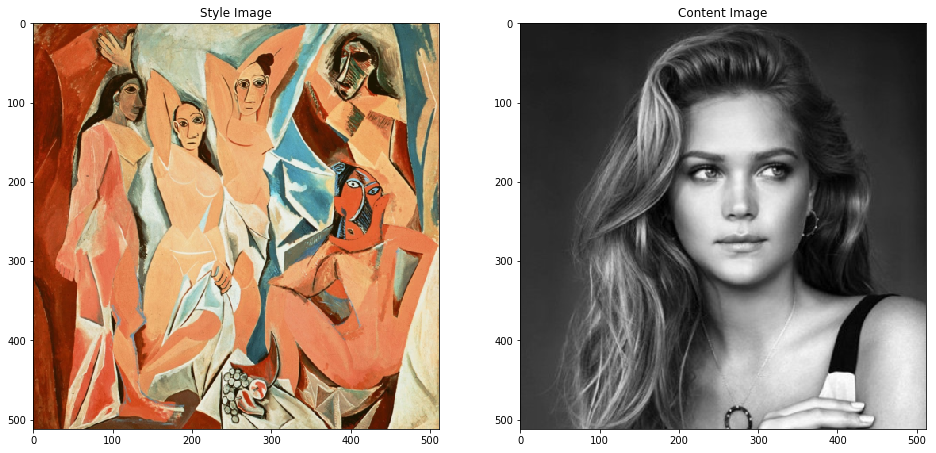

In [10]:
fig = plt.figure(figsize=(16,8))

fig.add_subplot(121)
plt.imshow(unloader(style_img.cpu().clone().squeeze(0))) # style
plt.title('Style Image')

fig.add_subplot(122)
plt.imshow(unloader(content_img.cpu().clone().squeeze(0))) # content
plt.title('Content Image')

plt.show()

# Loss Functions

In [11]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # probably some form of the feature map from within a convlayer
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [12]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [13]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Import VGG19 Model

In [15]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (Conv2d, ReLU, MaxPool2d,
Conv2d, ReLU…) aligned in the right order of depth. We need to add our
content loss and style loss layers immediately after the convolution
layer they are detecting. To do this we must create a new ``Sequential``
module that has content loss and style loss modules correctly inserted.




In [16]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # get content from the model's conv layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Next, we select the input image. You can use a copy of the content image
or white noise.




Gradient Descent
----------------

As Leon Gatys, the author of the algorithm, suggested `here <https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq>`__, we will use
L-BFGS algorithm to run our gradient descent. Unlike training a network,
we want to train the input image in order to minimise the content/style
losses. We will create a PyTorch L-BFGS optimizer ``optim.LBFGS`` and pass
our image to it as the tensor to optimize.




In [18]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

Finally, we must define a function that performs the neural transfer. For
each iteration of the networks, it is fed an updated input and computes
new losses. We will run the ``backward`` methods of each loss module to
dynamicaly compute their gradients. The optimizer requires a “closure”
function, which reevaluates the modul and returns the loss.

We still have one final constraint to address. The network may try to
optimize the input with values that exceed the 0 to 1 tensor range for
the image. We can address this by correcting the input values to be
between 0 to 1 each time the network is run.




In [19]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 10 == 0:
                print('Run {} Style Loss: {:4f} Content Loss: {:4f}'.format(run, style_score.item(), content_score.item()))
            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Finally, we can run the algorithm.




In [24]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=300)
print('Done')

Building the style transfer model..
Optimizing..


C:\Users\JAKfromSpace\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
C:\Users\JAKfromSpace\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Run [10] Style Loss: 8826.975586 Content Loss: 38.956730
Run [20] Style Loss: 4813.238770 Content Loss: 37.987713
Run [30] Style Loss: 3390.938965 Content Loss: 37.664539
Run [40] Style Loss: 2496.340088 Content Loss: 37.548843
Run [50] Style Loss: 1813.094971 Content Loss: 37.467564
Run [60] Style Loss: 1389.259277 Content Loss: 37.033623
Run [70] Style Loss: 1138.997314 Content Loss: 36.737320
Run [80] Style Loss: 949.674316 Content Loss: 36.628849
Run [90] Style Loss: 804.379822 Content Loss: 36.516827
Run [100] Style Loss: 720.109558 Content Loss: 36.387054
Run [110] Style Loss: 666.681641 Content Loss: 36.364731
Run [120] Style Loss: 628.073792 Content Loss: 36.352589
Run [130] Style Loss: 596.624084 Content Loss: 36.313869
Run [140] Style Loss: 568.312988 Content Loss: 36.352310
Run [150] Style Loss: 542.857727 Content Loss: 36.343529
Run [160] Style Loss: 523.241699 Content Loss: 36.199001
Run [170] Style Loss: 515.480591 Content Loss: 36.345200
Run [180] Style Loss: 499.528656 

<class 'torch.Tensor'> to <class 'PIL.Image.Image'>


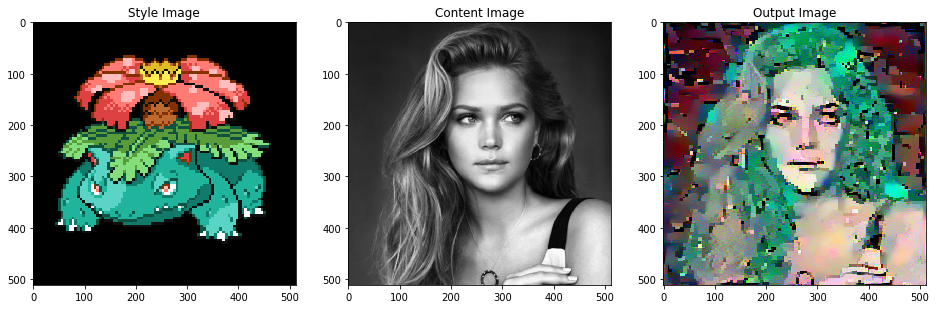

In [27]:
fig = plt.figure(figsize=(16,8))

print(type(output), 'to', type(unloader(style_img.cpu().clone().squeeze(0))))

fig.add_subplot(131)
plt.imshow(unloader(style_img.cpu().clone().squeeze(0)))
plt.title('Style Image')
fig.add_subplot(132)
plt.imshow(unloader(content_img.cpu().clone().squeeze(0)))
plt.title('Content Image')
fig.add_subplot(133)
plt.imshow(unloader(output.cpu().clone().squeeze(0)))
plt.title('Output Image')

plt.show()